In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

%matplotlib inline

In [6]:
cascade_path = './model/cv2/haarcascade_frontalface_alt2.xml'

In [142]:
image_dir_basepath = './images/'
names = ['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt','Irrfan_Khan','Jen_Aniston','Jen_Lawrence','Johnny_Depp','Pankaj_Tripathi','Robert_DowneyJr','Will_Smith']
image_size = 160

In [143]:
model_path = './model/keras/model/facenet_keras.h5'
model = load_model(model_path)

In [144]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [145]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        plt.imshow(img)
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [146]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [147]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

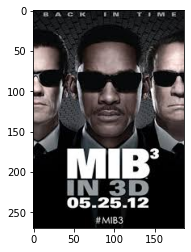

In [148]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

0.6388280391693115


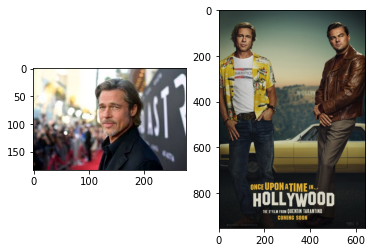

In [150]:
calc_dist_plot('Brad_Pitt0','Brad_Pitt2')

1.16139554977417


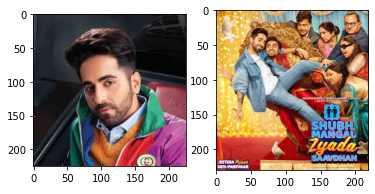

In [151]:
calc_dist_plot('Ayushmann_Khurrana0', 'Ayushmann_Khurrana1')

# plot

In [155]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [164]:
X_AnneHathaway = []
X_AyushmannKhurrana = []
X_BradPitt = []
X_IrrfanKhan=[]
X_JenAniston=[]
X_JenLawrence=[]
X_JohnnyDepp=[]
X_PankajTripathi=[]
X_RobertDowneyJr=[]
X_WillSmith=[]
for k, v in data.items():
    if 'Anne' in k:
        X_AnneHathaway.append(v['emb'])
    elif 'Ayushmann' in k:
        X_AyushmannKhurrana.append(v['emb'])
    elif 'Brad' in k:
        X_BradPitt.append(v['emb'])
    elif 'Jen_A' in k:
        X_JenAniston.append(v['emb'])
    elif 'Jen_L' in k:
        X_JenLawrence.append(v['emb'])
    elif 'Johnny' in k:
        X_JohnnyDepp.append(v['emb'])
    elif 'Pankaj' in k:
        X_PankajTripathi.append(v['emb'])
    elif 'Robert' in k:
        X_RobertDowneyJr.append(v['emb'])
    elif 'Will' in k:
        X_WillSmith.append(v['emb'])
    elif 'Irrfan' in k:
        X_IrrfanKhan.append(v['emb'])
        
Xd_BradPitt = pca.transform(X_BradPitt)
Xd_AnneHathaway = pca.transform(X_AnneHathaway)
Xd_AyushmannKhurrana = pca.transform(X_AyushmannKhurrana)
Xd_IrrfanKhan = pca.transform(X_IrrfanKhan)
Xd_JenAniston = pca.transform(X_JenAniston)
Xd_JenLawrence = pca.transform(X_JenLawrence)
Xd_JohnnyDepp = pca.transform(X_JohnnyDepp)
Xd_PankajTripathi = pca.transform(X_PankajTripathi)
Xd_RobertDowneyJr = pca.transform(X_RobertDowneyJr)
Xd_WillSmith = pca.transform(X_WillSmith)

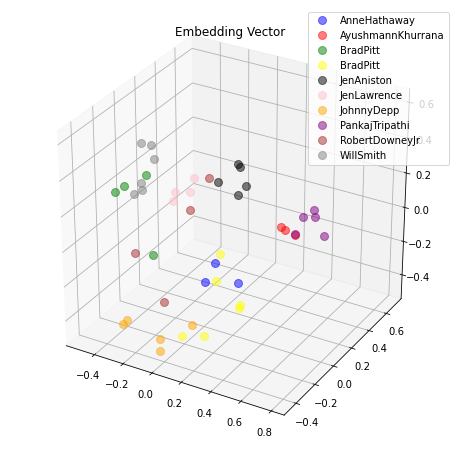

In [165]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_AnneHathaway[:,0], Xd_AnneHathaway[:,1], Xd_AnneHathaway[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='AnneHathaway')
ax.plot(Xd_AyushmannKhurrana[:,0], Xd_AyushmannKhurrana[:,1], Xd_AyushmannKhurrana[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='AyushmannKhurrana')
ax.plot(Xd_BradPitt[:,0], Xd_BradPitt[:,1], Xd_BradPitt[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='BradPitt')
ax.plot(Xd_IrrfanKhan[:,0], Xd_IrrfanKhan[:,1], Xd_IrrfanKhan[:,2],
        'o', markersize=8, color='yellow', alpha=0.5, label='BradPitt')
ax.plot(Xd_JenAniston[:,0], Xd_JenAniston[:,1], Xd_JenAniston[:,2],
        'o', markersize=8, color='black', alpha=0.5, label='JenAniston')
ax.plot(Xd_JenLawrence[:,0], Xd_JenLawrence[:,1], Xd_JenLawrence[:,2],
        'o', markersize=8, color='pink', alpha=0.5, label='JenLawrence')
ax.plot(Xd_JohnnyDepp[:,0], Xd_JohnnyDepp[:,1], Xd_JohnnyDepp[:,2],
        'o', markersize=8, color='orange', alpha=0.5, label='JohnnyDepp')
ax.plot(Xd_PankajTripathi[:,0], Xd_PankajTripathi[:,1], Xd_PankajTripathi[:,2],
        'o', markersize=8, color='purple', alpha=0.5, label='PankajTripathi')
ax.plot(Xd_RobertDowneyJr[:,0], Xd_RobertDowneyJr[:,1], Xd_RobertDowneyJr[:,2],
        'o', markersize=8, color='brown', alpha=0.5, label='RobertDowneyJr')
ax.plot(Xd_WillSmith[:,0], Xd_WillSmith[:,1], Xd_WillSmith[:,2],
        'o', markersize=8, color='grey', alpha=0.5, label='WillSmith')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()